In [3]:
#Dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## Data Description

| **Column**         | **Description**                                                                                                    |
|---------------------|--------------------------------------------------------------------------------------------------------------------|
| `yearID`           | The year of the season.                                                                                           |
| `lgID`             | League identifier (e.g., AL for American League, NL for National League).                                         |
| `teamID`           | Team identifier (unique abbreviation for the team in that season).                                                |
| `franchID`         | Franchise identifier (unique abbreviation for the franchise, used across seasons even if the team name changes).  |
| `divID`            | Division identifier (e.g., E for East, C for Central, W for West).                                                |
| `Rank`             | Team's rank within its division at the end of the season.                                                         |
| `G`                | Number of games played in the season.                                                                             |
| `Ghome`            | Number of home games played.                                                                                      |
| `W`                | Number of games won during the season.                                                                            |
| `L`                | Number of games lost during the season.                                                                           |
| `DivWin`           | Whether the team won its division (Y/N).                                                                          |
| `WCWin`            | Whether the team won the Wild Card (Y/N).                                                                         |
| `LgWin`            | Whether the team won its league championship (Y/N).                                                               |
| `WSWin`            | Whether the team won the World Series (Y/N).                                                                      |
| `R`                | Total runs scored by the team during the season.                                                                  |
| `AB`               | Total at-bats for the team during the season.                                                                     |
| `H`                | Total hits by the team during the season.                                                                         |
| `2B`               | Total doubles hit by the team during the season.                                                                  |
| `3B`               | Total triples hit by the team during the season.                                                                  |
| `HR`               | Total home runs hit by the team during the season.                                                                |
| `BB`               | Total walks (bases on balls) by the team during the season.                                                       |
| `SO`               | Total strikeouts by the team during the season.                                                                   |
| `SB`               | Total stolen bases by the team during the season.                                                                 |
| `CS`               | Total times caught stealing.                                                                                      |
| `HBP`              | Total hit-by-pitch occurrences for the team during the season.                                                    |
| `SF`               | Total sacrifice flies by the team during the season.                                                              |
| `RA`               | Total runs allowed by the team during the season.                                                                 |
| `ER`               | Total earned runs allowed by the team during the season.                                                          |
| `ERA`              | Earned run average (ERA) for the team's pitchers.                                                                 |
| `CG`               | Total complete games pitched by the team's pitchers during the season.                                            |
| `SHO`              | Total shutouts by the team's pitchers during the season.                                                          |
| `SV`               | Total saves recorded by the team's pitchers during the season.                                                    |
| `IPouts`           | Total outs recorded by the team's pitchers (used to calculate innings pitched, divide by 3).                      |
| `HA`               | Total hits allowed by the team's pitchers.                                                                        |
| `HRA`              | Total home runs allowed by the team's pitchers.                                                                   |
| `BBA`              | Total walks (bases on balls) allowed by the team's pitchers.                                                      |
| `SOA`              | Total strikeouts achieved by the team's pitchers.                                                                 |
| `E`                | Total errors committed by the team.                                                                               |
| `DP`               | Total double plays executed by the team.                                                                          |
| `FP`               | Fielding percentage for the team.                                                                                 |
| `name`             | Name of the team during that season.                                                                              |
| `park`             | Name of the home ballpark used by the team during that season.                                                    |
| `attendance`       | Total attendance for the team's home games during the season.                                                     |
| `BPF`              | Batting park factor, measuring the park's effect on batting performance (higher = more hitter-friendly).          |
| `PPF`              | Pitching park factor, measuring the park's effect on pitching performance (higher = more pitcher-friendly).       |
| `teamIDBR`         | Team ID used in Baseball Reference database.                                                                      |
| `teamIDlahman45`   | Team ID used in the Lahman database (version 4.5).                                                                |
| `teamIDretro`      | Team ID used in Retrosheet database.                                                                               |


## EDA

In [4]:
#Data from 1980 to 2023
df = pd.read_csv('Teams.csv')

In [5]:
#print(df.info())
#print(df.head())

In [6]:
#Convert Categorical variables
binary_cols = ['DivWin', 'WCWin', 'LgWin', 'WSWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

In [7]:
#Create a New Column to see if the team made it to playoff
df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)

In [8]:
print(df['WSWin'].value_counts())

WSWin
0    835
1     29
Name: count, dtype: int64


In [9]:
# Select only numeric columns
# List of columns to exclude
exclude_cols = ['yearID', 'Rank', 'G', 'Ghome', 'E', 'DP', 'BPF', 'PPF', 'attendance']
numeric_cols = numeric_cols.drop(columns=exclude_cols, errors='ignore')

# Compute the correlation matrix
corr = numeric_cols.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


NameError: name 'numeric_cols' is not defined

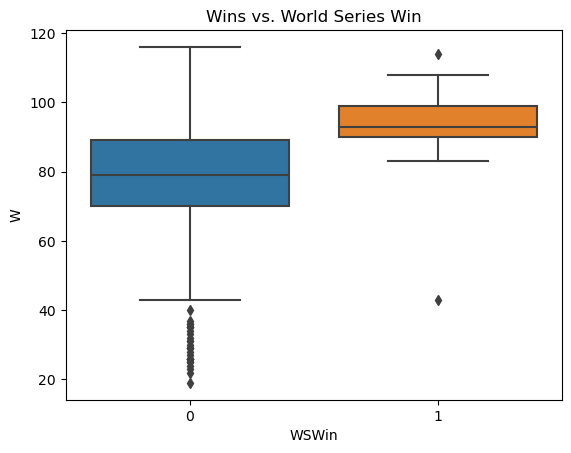

In [10]:
sns.boxplot(x='WSWin', y='W', data=df)
plt.title('Wins vs. World Series Win')
plt.show()

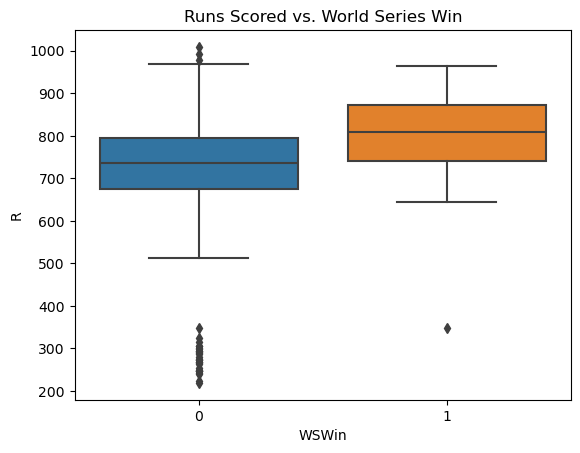

In [11]:
sns.boxplot(x='WSWin', y='R', data=df)
plt.title('Runs Scored vs. World Series Win')
plt.show()

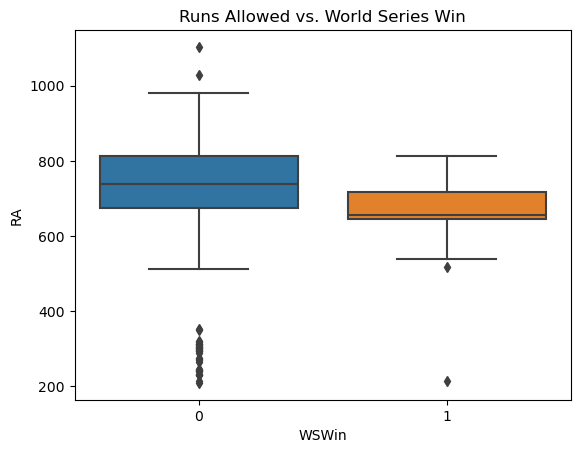

In [13]:
sns.boxplot(x='WSWin', y='RA', data=df)
plt.title('Runs Allowed vs. World Series Win')
plt.show()

In [14]:
X = df.select_dtypes(include=[np.number]).drop(['WSWin', 'Playoff'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       feature           VIF
0       yearID  4.007038e+05
1         Rank  2.913573e+01
2            G  1.127261e+06
3        Ghome  1.861125e+04
4            W  2.810358e+05
5            L  2.813207e+05
6       DivWin  3.503484e+00
7        WCWin  1.824092e+00
8        LgWin  1.346261e+00
9            R  1.782703e+03
10          AB  6.772544e+04
11           H  5.125100e+03
12          2B  2.123359e+02
13          3B  1.617663e+01
14          HR  1.151562e+02
15          BB  1.856689e+02
16          SO  2.136848e+02
17          SB  1.952440e+01
18          CS  3.143216e+01
19         HBP  1.957554e+01
20          SF  4.534440e+01
21          RA  6.777278e+03
22          ER  9.450979e+03
23         ERA  3.022486e+03
24          CG  5.461485e+00
25         SHO  1.291565e+01
26          SV  9.040263e+01
27      IPouts  6.532522e+04
28          HA  1.982350e+03
29         HRA  1.330883e+02
30         BBA  1.765253e+02
31         SOA  2.256626e+02
32           E  1.628557e+02
33          DP

In [15]:
df.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,Playoff
0,1995,AL,BAL,BAL,E,3,144,72,71,73,...,0.986,Baltimore Orioles,Oriole Park at Camden Yards,3098475,102,101,BAL,BAL,BAL,0
1,1995,AL,BOS,BOS,E,1,144,72,86,58,...,0.978,Boston Red Sox,Fenway Park II,2164410,103,103,BOS,BOS,BOS,1
2,1995,AL,CAL,ANA,W,2,145,72,78,67,...,0.982,California Angels,Anaheim Stadium,1748680,99,99,CAL,CAL,CAL,0
3,1995,AL,CHA,CHW,C,3,145,72,68,76,...,0.980,Chicago White Sox,Comiskey Park II,1609773,96,95,CHW,CHA,CHA,0
4,1995,AL,CLE,CLE,C,1,144,72,100,44,...,0.982,Cleveland Indians,Jacobs Field,2842745,101,99,CLE,CLE,CLE,1


In [16]:
df['Pythagorean_Win%'] = df['R']**2 / (df['R']**2 + df['RA']**2)

In [17]:
df['Win%'] = df['W'] / (df['W'] + df['L'])

## Modeling

In [18]:
df = df.drop(['name', 'park'], axis=1)

In [19]:
df = pd.get_dummies(df, columns=['lgID', 'teamID', 'franchID', 'divID', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'], drop_first=True)

In [20]:
# Shift features by one year to use last season's data for predictions
df = df.sort_values(by=['teamID', 'yearID'])
shifted_cols = ['W', 'L', 'Win%', 'R', 'RA', 'ERA', 'FP', 'attendance']  # Add relevant features
for col in shifted_cols:
    df[col + '_prev'] = df.groupby('teamID')[col].shift(1)

KeyError: 'teamID'

In [21]:
df = df.drop(['W', 'L', 'Win%', 'DivWin', 'WCWin', 'WSWin', 'R', 'RA', 'ERA', 'FP'], axis=1)

In [22]:
df = df.dropna()  # Drop rows with missing values

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load Data
df = pd.read_csv('Teams.csv')

# Convert categorical columns to binary
binary_cols = ['DivWin', 'WCWin', 'LgWin', 'WSWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Create a column for playoff qualification
df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)

# Add Pythagorean win percentage and Win percentage
df['Pythagorean_Win%'] = df['R']**2 / (df['R']**2 + df['RA']**2)
df['Win%'] = df['W'] / (df['W'] + df['L'])

# Shift features to use last season's data
df = df.sort_values(by=['teamID', 'yearID'])
shifted_cols = ['W', 'L', 'Win%', 'R', 'RA', 'ERA', 'FP', 'attendance']
for col in shifted_cols:
    df[col + '_prev'] = df.groupby('teamID')[col].shift(1)

# Drop irrelevant columns
df = df.drop(['name', 'park', 'W', 'L', 'Win%', 'DivWin', 'WCWin', 'R', 'RA', 'ERA', 'FP'], axis=1)

# Drop rows with missing values
df = df.dropna()

# Encode categorical columns
categorical_cols = ['lgID', 'franchID', 'divID', 'teamIDBR', 'teamIDlahman45', 'teamIDretro']
for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

# Encode teamID and preserve mapping
label_encoder = LabelEncoder()
df['teamID_encoded'] = label_encoder.fit_transform(df['teamID'])
team_mapping = dict(zip(df['teamID_encoded'], df['teamID']))

# Drop original teamID column
df = df.drop(['teamID'], axis=1)

# Split data into training and testing sets
train = df[df['yearID'] <= 2015]
test = df[df['yearID'] > 2015].copy()

# Prepare features and labels
X_train = train.drop(['yearID', 'Playoff', 'WSWin'], axis=1)
y_train_playoff = train['Playoff']
y_train_ws = train['WSWin']

X_test = test.drop(['yearID', 'Playoff', 'WSWin'], axis=1)
y_test_playoff = test['Playoff']
y_test_ws = test['WSWin']

# Train Playoff Model
playoff_model = RandomForestClassifier(n_estimators=200, random_state=42)
playoff_model.fit(X_train, y_train_playoff)

# Predict probabilities for playoff qualification
test['Playoff_Prob'] = playoff_model.predict_proba(X_test)[:, 1]

# Select playoff teams
playoff_teams = test[test['Playoff_Prob'] >= 0.5].copy()

# Train World Series Model
ws_model = RandomForestClassifier(n_estimators=200, random_state=42)
ws_model.fit(X_train, y_train_ws)

# Align features for playoff teams
features = X_train.columns
X_playoff_teams = playoff_teams[features]

# Predict World Series probabilities
playoff_teams['WSWin_Prob'] = ws_model.predict_proba(X_playoff_teams)[:, 1]

# Identify World Series winners
predicted_winners = playoff_teams.loc[
    playoff_teams.groupby('yearID')['WSWin_Prob'].idxmax(),
    ['yearID', 'teamID_encoded', 'WSWin_Prob']
]

# Map teamID_encoded back to original teamID
predicted_winners['teamID'] = predicted_winners['teamID_encoded'].map(team_mapping)

# Print predicted winners
print(predicted_winners)


     yearID  teamID_encoded  WSWin_Prob teamID
641    2016               7       0.340    CHN
674    2017              16       0.325    LAN
685    2018               4       0.365    BOS
719    2019              13       0.375    HOU
756    2020              31       0.450    TBA
779    2021              13       0.415    HOU
809    2022              13       0.245    HOU
847    2023              32       0.260    TEX


In [29]:
print(X_train.dtypes)


lgID                  int64
franchID              int64
divID                 int64
Rank                  int64
G                     int64
Ghome                 int64
LgWin                 int64
AB                    int64
H                     int64
2B                    int64
3B                    int64
HR                    int64
BB                    int64
SO                    int64
SB                    int64
CS                    int64
HBP                   int64
SF                    int64
ER                    int64
CG                    int64
SHO                   int64
SV                    int64
IPouts                int64
HA                    int64
HRA                   int64
BBA                   int64
SOA                   int64
E                     int64
DP                    int64
attendance            int64
BPF                   int64
PPF                   int64
teamIDBR              int64
teamIDlahman45        int64
teamIDretro           int64
Pythagorean_Win%    

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('Teams.csv')

# Convert 'DivWin', 'WCWin', and 'WSWin' to binary
binary_cols = ['DivWin', 'WCWin', 'WSWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Create 'Playoff' indicator
df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)

# Feature Engineering
df['Pythagorean_Win%'] = df['R']**2 / (df['R']**2 + df['RA']**2)
df['Run_Diff'] = df['R'] - df['RA']

# Sort the data
df = df.sort_values(by=['teamID', 'yearID'])

# Rolling averages using transform
df['W_last3'] = df.groupby('teamID')['W'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
df['Run_Diff_last3'] = df.groupby('teamID')['Run_Diff'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
df['Pyth_Win%_last3'] = df.groupby('teamID')['Pythagorean_Win%'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
df['Playoff_prev'] = df.groupby('teamID')['Playoff'].transform(lambda x: x.shift(1))

# Select features
features = ['W_last3', 'Run_Diff_last3', 'Pyth_Win%_last3', 'Playoff_prev']

# Drop rows with missing values
df = df.dropna(subset=features + ['WSWin'])

# Encode 'teamID'
label_encoder = LabelEncoder()
df['teamID_encoded'] = label_encoder.fit_transform(df['teamID'])

# Define X and y
X = df[features]
y = df['WSWin']

# Split data into training and testing sets
train_year = 2015
X_train = X[df['yearID'] <= train_year]
X_test = X[df['yearID'] > train_year]
y_train = y[df['yearID'] <= train_year]
y_test = y[df['yearID'] > train_year]

# Retain 'yearID' and 'teamID' for interpretation
test_yearID = df['yearID'][df['yearID'] > train_year]
test_teamID = df['teamID'][df['yearID'] > train_year]

# Train the Gradient Boosting model
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = gbc_model.predict_proba(X_test)[:, 1]

# Create a DataFrame with predictions
predictions = pd.DataFrame({
    'yearID': test_yearID.values,
    'teamID': test_teamID.values,
    'WSWin_Prob': y_pred_proba
})

# Rank teams by predicted probability each season
predictions['Rank'] = predictions.groupby('yearID')['WSWin_Prob'].rank(ascending=False, method='first')

# Evaluate the model using Mean Reciprocal Rank
actual_winners = df[df['yearID'] > train_year][['yearID', 'teamID', 'WSWin']]
actual_winners = actual_winners[actual_winners['WSWin'] == 1]

# Merge predictions with actual winners
evaluation = pd.merge(predictions, actual_winners[['yearID', 'teamID']], on=['yearID', 'teamID'], how='left', indicator=True)
evaluation['Relevant'] = evaluation['_merge'] == 'both'

# Calculate Reciprocal Rank
mrr_list = []
for year in evaluation['yearID'].unique():
    year_data = evaluation[evaluation['yearID'] == year]
    if year_data['Relevant'].any():
        rank = year_data.loc[year_data['Relevant'], 'Rank'].values[0]
        mrr_list.append(1 / rank)
    else:
        mrr_list.append(0)
mrr = np.mean(mrr_list)

print(f"Mean Reciprocal Rank (MRR): {mrr:.2f}")

# Display the ranks of actual winners
winners_rank = evaluation[evaluation['Relevant']].sort_values('yearID')[['yearID', 'teamID', 'Rank', 'WSWin_Prob']]
print("\nRank of Actual Winners:")
print(winners_rank)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gbc_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Mean Reciprocal Rank (MRR): 0.12

Rank of Actual Winners:
     yearID teamID  Rank  WSWin_Prob
40     2016    CHN   7.0    0.032786
81     2017    HOU  19.0    0.005054
26     2018    BOS  14.0    0.007178
235    2019    WAS  15.0    0.006257
108    2020    LAN   3.0    0.037097
13     2021    ATL   6.0    0.011216
86     2022    HOU  13.0    0.003382
223    2023    TEX  28.0    0.001329

Feature Importances:
           Feature  Importance
1   Run_Diff_last3    0.375010
2  Pyth_Win%_last3    0.359219
0          W_last3    0.262053
3     Playoff_prev    0.003718


In [32]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model.fit(X_train, y_train)
y_pred_proba = brf_model.predict_proba(X_test)[:, 1]

In [33]:
# Create a DataFrame with predictions
predictions = pd.DataFrame({
    'yearID': test_yearID.values,
    'teamID': test_teamID.values,
    'WSWin_Prob': y_pred_proba
})

# Rank teams by predicted probability each season
predictions['Rank'] = predictions.groupby('yearID')['WSWin_Prob'].rank(ascending=False, method='first')

# Evaluate the model using Mean Reciprocal Rank
actual_winners = df[df['yearID'] > train_year][['yearID', 'teamID', 'WSWin']]
actual_winners = actual_winners[actual_winners['WSWin'] == 1]

# Merge predictions with actual winners
evaluation = pd.merge(predictions, actual_winners[['yearID', 'teamID']], on=['yearID', 'teamID'], how='left', indicator=True)
evaluation['Relevant'] = evaluation['_merge'] == 'both'

# Calculate Reciprocal Rank
mrr_list = []
for year in evaluation['yearID'].unique():
    year_data = evaluation[evaluation['yearID'] == year]
    if year_data['Relevant'].any():
        rank = year_data.loc[year_data['Relevant'], 'Rank'].values[0]
        mrr_list.append(1 / rank)
    else:
        mrr_list.append(0)
mrr = np.mean(mrr_list)

print(f"Mean Reciprocal Rank (MRR): {mrr:.2f}")

# Display the ranks of actual winners
winners_rank = evaluation[evaluation['Relevant']].sort_values('yearID')[['yearID', 'teamID', 'Rank', 'WSWin_Prob']]
print("\nRank of Actual Winners:")
print(winners_rank)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gbc_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Mean Reciprocal Rank (MRR): 0.21

Rank of Actual Winners:
     yearID teamID  Rank  WSWin_Prob
40     2016    CHN   4.0        0.71
81     2017    HOU  22.0        0.35
26     2018    BOS   8.0        0.65
235    2019    WAS  10.0        0.64
108    2020    LAN   2.0        0.92
13     2021    ATL   8.0        0.53
86     2022    HOU   2.0        0.68
223    2023    TEX  28.0        0.01

Feature Importances:
           Feature  Importance
1   Run_Diff_last3    0.375010
2  Pyth_Win%_last3    0.359219
0          W_last3    0.262053
3     Playoff_prev    0.003718


In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load historical data
df = pd.read_csv('Teams.csv')

# Convert 'DivWin', 'WCWin', and 'WSWin' to binary
binary_cols = ['DivWin', 'WCWin', 'WSWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Create 'Playoff' indicator
df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)

# Feature Engineering
df['Pythagorean_Win%'] = df['R']**2 / (df['R']**2 + df['RA']**2)
df['Run_Diff'] = df['R'] - df['RA']
df['Runs_per_Game'] = df['R'] / df['G']

# Sort the data
df = df.sort_values(by=['teamID', 'yearID'])

# Encode 'teamID' for identification
label_encoder = LabelEncoder()
df['teamID_encoded'] = label_encoder.fit_transform(df['teamID'])

# Define features
features = ['W_last3', 'Run_Diff_last3', 'Pyth_Win%_last3', 'Playoff_prev', 'Runs_per_Game_last3']

# Function to create lagged features
def create_lagged_features(data):
    # Get last three seasons for each team
    last_three_seasons = data.groupby('teamID').apply(lambda x: x.nlargest(3, 'yearID')).reset_index(drop=True)
    
    # Compute lagged features
    lagged_features = last_three_seasons.groupby('teamID').agg({
        'W': 'mean',
        'Run_Diff': 'mean',
        'Pythagorean_Win%': 'mean',
        'Playoff': 'last',
        'Runs_per_Game': 'mean'
    }).reset_index()
    
    # Rename columns to match feature names
    lagged_features.rename(columns={
        'W': 'W_last3',
        'Run_Diff': 'Run_Diff_last3',
        'Pythagorean_Win%': 'Pyth_Win%_last3',
        'Playoff': 'Playoff_prev',
        'Runs_per_Game': 'Runs_per_Game_last3'
    }, inplace=True)
    
    return lagged_features

# Function to evaluate the model
def evaluate_model(df, start_year, end_year):
    results = []
    years = range(start_year, end_year)
    
    for year in years:
        # Split data into training and testing sets
        train_data = df[df['yearID'] < year]
        test_data = df[df['yearID'] == year]
        
        # Prepare lagged features for training data
        lagged_features_train = create_lagged_features(train_data)
        df_train = train_data[['teamID', 'yearID', 'WSWin']].drop_duplicates()
        df_train = df_train.merge(lagged_features_train, on='teamID', how='left')
        df_train = df_train.dropna(subset=features + ['WSWin'])
        
        # Prepare lagged features for test data
        lagged_features_test = create_lagged_features(train_data)
        df_test = test_data[['teamID', 'yearID', 'WSWin']].drop_duplicates()
        df_test = df_test.merge(lagged_features_test, on='teamID', how='left')
        df_test = df_test.dropna(subset=features + ['WSWin'])
        
        # Define X and y for training
        X_train = df_train[features]
        y_train = df_train['WSWin']
        
        # Define X and y for testing
        X_test = df_test[features]
        y_test = df_test['WSWin']
        test_teams = df_test[['teamID', 'yearID']].reset_index(drop=True)
        
        # Check if we have data to train and test
        if X_train.empty or X_test.empty:
            continue
        
        # Train the model
        xgb_model = xgb.XGBClassifier(scale_pos_weight=30, random_state=42)
        xgb_model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
        
        # Compile results
        predictions = test_teams.copy()
        predictions['WSWin_Prob'] = y_pred_proba
        predictions['WSWin'] = y_test.values
        
        results.append(predictions)
    
    # Concatenate results
    results_df = pd.concat(results, ignore_index=True)
    return results_df

# Evaluate model from 2010 to 2022
results_df = evaluate_model(df, start_year=2010, end_year=2023)

# Rank teams by predicted probability each season
results_df['Rank'] = results_df.groupby('yearID')['WSWin_Prob'].rank(ascending=False, method='first')

# Calculate MRR
def calculate_mrr(results_df):
    mrr_list = []
    for year in results_df['yearID'].unique():
        year_data = results_df[results_df['yearID'] == year]
        winner = year_data[year_data['WSWin'] == 1]
        if not winner.empty:
            rank = winner['Rank'].values[0]
            mrr_list.append(1 / rank)
        else:
            mrr_list.append(0)
    mrr = np.mean(mrr_list)
    return mrr

mrr = calculate_mrr(results_df)
print(f"Mean Reciprocal Rank (MRR): {mrr:.2f}")

# Display ranks of actual winners
winners_rank = results_df[results_df['WSWin'] == 1][['yearID', 'teamID', 'Rank', 'WSWin_Prob']]
print("\nRank of Actual Winners:")
print(winners_rank.sort_values('yearID'))

# Calculate Precision at K
def precision_at_k(results_df, K):
    hit_list = []
    for year in results_df['yearID'].unique():
        year_data = results_df[results_df['yearID'] == year]
        top_k = year_data.nsmallest(K, 'Rank')
        if top_k['WSWin'].sum() > 0:
            hit_list.append(1)
        else:
            hit_list.append(0)
    precision = np.mean(hit_list)
    return precision

precision = precision_at_k(results_df, K=5)
print(f"\nPrecision at 5: {precision:.2f}")

# Feature importances
lagged_features_all = create_lagged_features(df)
df_all = df[['teamID', 'yearID', 'WSWin']].drop_duplicates()
df_all = df_all.merge(lagged_features_all, on='teamID', how='left')
df_all = df_all.dropna(subset=features + ['WSWin'])

X_all = df_all[features]
y_all = df_all['WSWin']

xgb_model = xgb.XGBClassifier(scale_pos_weight=30, random_state=42)
xgb_model.fit(X_all, y_all)

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Mean Reciprocal Rank (MRR): 0.16

Rank of Actual Winners:
     yearID teamID  Rank  WSWin_Prob
24     2010    SFN  25.0    0.002439
55     2011    SLN   5.0    0.664493
83     2012    SFN   8.0    0.648057
92     2013    BOS   2.0    0.788420
143    2014    SFN   4.0    0.775832
160    2015    KCA  24.0    0.003415
184    2016    CHN  24.0    0.002069
219    2017    HOU  16.0    0.005022
242    2018    BOS   2.0    0.816804
298    2019    WAS  13.0    0.011924
312    2020    LAN  16.0    0.006766
330    2021    ATL  10.0    0.542829
369    2022    HOU   9.0    0.535187

Precision at 5: 0.31

Feature Importances:
               Feature  Importance
3         Playoff_prev    0.671687
2      Pyth_Win%_last3    0.139161
4  Runs_per_Game_last3    0.095024
0              W_last3    0.051820
1       Run_Diff_last3    0.042308


In [35]:
import pandas as pd
import numpy as np

# Load historical data
df = pd.read_csv('Teams.csv')

# Preprocessing steps (same as before)
binary_cols = ['DivWin', 'WCWin', 'WSWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)
df['Pythagorean_Win%'] = df['R']**2 / (df['R']**2 + df['RA']**2)
df['Run_Diff'] = df['R'] - df['RA']
df['Runs_per_Game'] = df['R'] / df['G']
df = df.sort_values(by=['teamID', 'yearID'])
df.head()


,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,Playoff,Pythagorean_Win%,Run_Diff,Runs_per_Game
56,1997,AL,ANA,ANA,W,2,162,82,84,78,...,1767330,102,102,ANA,ANA,ANA,0,0.521555,35,5.117284
84,1998,AL,ANA,ANA,W,2,162,81,85,77,...,2519280,102,102,ANA,ANA,ANA,0,0.502548,4,4.858025
114,1999,AL,ANA,ANA,W,4,162,81,70,92,...,2253123,99,100,ANA,ANA,ANA,0,0.425595,-115,4.388889
144,2000,AL,ANA,ANA,W,3,162,81,82,80,...,2066982,102,103,ANA,ANA,ANA,0,0.497115,-5,5.333333
174,2001,AL,ANA,ANA,W,3,162,81,75,87,...,2000919,101,101,ANA,ANA,ANA,0,0.472575,-39,4.265432


## More test

In [36]:
# Load the Teams data
df = pd.read_csv('Teams.csv')

# Convert categorical win indicators to binary
binary_cols = ['DivWin', 'WCWin', 'WSWin', 'LgWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Create 'Playoff' indicator
df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)

# Filter data from 1995 onwards
df = df[df['yearID'] >= 1995].reset_index(drop=True)

# Fill missing values with zeros
df.fillna(0, inplace=True)


In [37]:
# Basic performance metrics
df['WinPct'] = df['W'] / df['G']
df['RunDiff'] = df['R'] - df['RA']
df['Pythagorean_WinPct'] = df['R']**2 / (df['R']**2 + df['RA']**2)
df['RunsPerGame'] = df['R'] / df['G']
df['ERA'] = df['ERA']  # Already in dataset
df['WHIP'] = (df['HA'] + df['BBA']) / df['IPouts'] * 3  # Walks plus Hits per Inning Pitched


In [38]:
def create_lagged_features(data, features, lags=3):
    data = data.sort_values(['teamID', 'yearID'])
    lagged_data = data[['teamID', 'yearID']].copy()
    for feature in features:
        for lag in range(1, lags+1):
            lagged_feature_name = f'{feature}_lag{lag}'
            lagged_data[lagged_feature_name] = data.groupby('teamID')[feature].shift(lag)
    return lagged_data


In [39]:
# Features to lag
features_to_lag = ['WinPct', 'RunDiff', 'Pythagorean_WinPct', 'RunsPerGame', 'ERA', 'WHIP']

# Create lagged features
lagged_features = create_lagged_features(df, features_to_lag, lags=3)

# Combine original and lagged features
df = df.merge(lagged_features, on=['teamID', 'yearID'], how='left')

# Drop rows with missing lagged features
df.dropna(subset=[f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)


In [40]:
# Final feature list
feature_cols = [f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)]


In [41]:
# Encode teamID
label_encoder = LabelEncoder()
df['teamID_encoded'] = label_encoder.fit_transform(df['teamID'])


In [42]:
# Target variable
target = 'WSWin'

# Features
X = df[feature_cols]
y = df[target]


In [43]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [44]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)


In [45]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

In [46]:
# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)


In [47]:
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

In [49]:
# Training data: up to 2021
train_data = df[df['yearID'] < 2023]
X_train = train_data[feature_cols]
y_train = train_data[target]

# Testing data: 2022
test_data = df[df['yearID'] == 2023]
X_test = test_data[feature_cols]
y_test = test_data[target]

# Standardize features using the same scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [50]:
# Apply SMOTE to training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)


In [55]:
# Get unique teams from 2022
teams_2022 = df[df['yearID'] == 2023]['teamID'].unique()

# Create DataFrame for 2023 predictions
prediction_df = pd.DataFrame({'teamID': teams_2022, 'yearID': 2023})

# Get the latest lagged features for each team
latest_features = []
for team in teams_2022:
    team_data = df[df['teamID'] == team].sort_values('yearID', ascending=False).head(3)
    if len(team_data) < 3:
        continue  # Skip teams with insufficient data
    features = {'teamID': team, 'yearID': 2023}
    for lag in range(1, 4):
        for feat in features_to_lag:
            features[f'{feat}_lag{lag}'] = team_data.iloc[lag-1][feat]
    latest_features.append(features)

prediction_df = pd.DataFrame(latest_features)

# Handle missing values
prediction_df.fillna(0, inplace=True)

# Select features
X_pred = prediction_df[feature_cols]

# Standardize features using the same scaler
X_pred_scaled = scaler.transform(X_pred)


## 2024

In [58]:
# Load the Teams data
df = pd.read_csv('Teams.csv')

# Convert categorical win indicators to binary
binary_cols = ['DivWin', 'WCWin', 'WSWin', 'LgWin']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Create 'Playoff' indicator
df['Playoff'] = df[['DivWin', 'WCWin']].max(axis=1)

# Ensure data includes up to 2023
df = df[df['yearID'] <= 2023].reset_index(drop=True)

# Fill missing values with zeros
df.fillna(0, inplace=True)


In [59]:
# Basic performance metrics
df['WinPct'] = df['W'] / df['G']
df['RunDiff'] = df['R'] - df['RA']
df['Pythagorean_WinPct'] = df['R']**2 / (df['R']**2 + df['RA']**2)
df['RunsPerGame'] = df['R'] / df['G']

# Check if 'HA', 'BBA', 'IPouts' are available for WHIP calculation
required_columns = ['HA', 'BBA', 'IPouts']
if all(col in df.columns for col in required_columns):
    df['WHIP'] = (df['HA'] + df['BBA']) / (df['IPouts'] / 3)
else:
    print("WHIP cannot be calculated due to missing columns. Excluding WHIP from features.")


In [60]:
def create_lagged_features(data, features, lags=3):
    data = data.sort_values(['teamID', 'yearID'])
    lagged_data = data[['teamID', 'yearID']].copy()
    for feature in features:
        for lag in range(1, lags+1):
            lagged_feature_name = f'{feature}_lag{lag}'
            lagged_data[lagged_feature_name] = data.groupby('teamID')[feature].shift(lag)
    return lagged_data


In [61]:
# Features to lag
features_to_lag = ['WinPct', 'RunDiff', 'Pythagorean_WinPct', 'RunsPerGame']
# Include 'WHIP' if it was calculated
if 'WHIP' in df.columns:
    features_to_lag.append('WHIP')

# Create lagged features
lagged_features = create_lagged_features(df, features_to_lag, lags=3)

# Combine original and lagged features
df = df.merge(lagged_features, on=['teamID', 'yearID'], how='left')

# Drop rows with missing lagged features
df.dropna(subset=[f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)


In [62]:
# Final feature list
feature_cols = [f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)]


In [63]:
# Training data: up to 2023
train_data = df[df['yearID'] <= 2023]

# Target variable
target = 'WSWin'

# Features and target
X_train = train_data[feature_cols]
y_train = train_data[target]


In [64]:
# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [65]:
# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)


In [66]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}


In [67]:
# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)


In [68]:
xgb_clf = xgb.XGBClassifier(random_state=42)


In [69]:
# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Best estimator
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    return _av

Best parameters found:  {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [70]:
# Testing data: 2023
test_data = df[df['yearID'] == 2023]
X_test = test_data[feature_cols]
y_test = test_data[target]

# Apply scaler to test data
X_test_scaled = scaler.transform(X_test)

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Predict classes
y_pred = best_model.predict(X_test_scaled)

# Classification report
print("Classification Report for 2023:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score for 2023: {roc_auc:.4f}")


Classification Report for 2023:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.50      1.00      0.67         1

    accuracy                           0.97        30
   macro avg       0.75      0.98      0.82        30
weighted avg       0.98      0.97      0.97        30

ROC AUC Score for 2023: 1.0000


In [71]:
# Get unique teams from 2023
teams_2023 = df[df['yearID'] == 2023]['teamID'].unique()

# Create DataFrame for 2024 predictions
prediction_df = pd.DataFrame({'teamID': teams_2023, 'yearID': 2024})

# Get the latest lagged features for each team
latest_features = []
for team in teams_2023:
    team_data = df[df['teamID'] == team].sort_values('yearID', ascending=False).head(3)
    if len(team_data) < 3:
        continue  # Skip teams with insufficient data
    features = {'teamID': team, 'yearID': 2024}
    for lag in range(1, 4):
        for feat in features_to_lag:
            features[f'{feat}_lag{lag}'] = team_data.iloc[lag-1][feat]
    latest_features.append(features)

prediction_df = pd.DataFrame(latest_features)

# Handle missing values
prediction_df.fillna(0, inplace=True)

# Select features
X_pred = prediction_df[feature_cols]

# Standardize features using the same scaler
X_pred_scaled = scaler.transform(X_pred)


In [72]:
# Predict probabilities
prediction_df['WSWin_Prob'] = best_model.predict_proba(X_pred_scaled)[:, 1]

# Rank teams based on predicted probabilities
prediction_df['Rank'] = prediction_df['WSWin_Prob'].rank(ascending=False, method='first')

# Sort teams by rank
prediction_df.sort_values('Rank', inplace=True)

# Display top 3 predictions
top_3_2024 = prediction_df.head(3)[['teamID', 'WSWin_Prob', 'Rank']]
print("Top 3 Predicted Teams for 2024:")
print(top_3_2024)


Top 3 Predicted Teams for 2024:
   teamID  WSWin_Prob  Rank
21    MIA    0.804348   1.0
14    TOR    0.599633   2.0
3     CLE    0.531935   3.0


In [73]:
# Load Teams.csv again to get team names
teams_info = df[['teamID', 'name']].drop_duplicates()
prediction_df = prediction_df.merge(teams_info, on='teamID', how='left')

# Display top 3 teams with names
top_3_2024 = prediction_df.head(3)[['teamID', 'name', 'WSWin_Prob', 'Rank']]
print("Top 3 Predicted Teams for 2024:")
print(top_3_2024)


Top 3 Predicted Teams for 2024:
  teamID               name  WSWin_Prob  Rank
0    MIA      Miami Marlins    0.804348   1.0
1    TOR  Toronto Blue Jays    0.599633   2.0
2    CLE  Cleveland Indians    0.531935   3.0


In [74]:
# Select necessary columns and sort by rank
output_df = prediction_df[['teamID', 'name', 'WSWin_Prob', 'Rank']].sort_values('Rank')

# Save to JSON file
output_df.to_json('predictions_2024.json', orient='records')


In [75]:
# Save to CSV file
output_df.to_csv('predictions_2024.csv', index=False)
